In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
permits = pd.read_csv('./datasets/building_permits_2017.csv')
permits.head()

,permit_id,issued,cost,lat,lng
0,2017032777,2017-05-24,226201.0,36.198241,-86.742235
1,2017061156,2017-10-23,15000.0,36.151554,-86.830222
2,2017074521,2017-11-20,13389.0,36.034239,-86.708892
3,2017035041,2017-05-30,40000.0,36.128659,-86.841815
4,2017000049,2017-01-09,268107.0,36.045042,-86.616211


In [3]:
council_districts = gpd.read_file('./datasets/council_districts.geojson')[['district','geometry']]
council_districts.head()

,district,geometry
0,1,(POLYGON ((-86.90738248774342 36.3905151283193...
1,2,(POLYGON ((-86.75902399986667 36.2309080000732...
2,8,(POLYGON ((-86.72850199989709 36.2832840002146...
3,9,(POLYGON ((-86.68680500011935 36.2867050001350...
4,4,(POLYGON ((-86.74488864807594 36.0531632050230...


## Finding counts from a spatial join

In [4]:
# Create a shapely Point from lat and lng
permits['geometry'] = permits.apply(lambda x: Point((x.lng , x.lat)), axis = 1)

# Build a GeoDataFrame: permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs = council_districts.crs, geometry = permits.geometry)

# Spatial join of permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op = 'within')
permits_by_district.head(2)

,permit_id,issued,cost,lat,lng,geometry,index_right,district
0,2017032777,2017-05-24,226201.0,36.198241,-86.742235,POINT (-86.74223499999999 36.198241),5,5
68,2017053890,2017-09-05,0.0,36.185442,-86.768239,POINT (-86.76823900000001 36.185442),5,5


In [5]:
# Create permit_counts
permit_counts = permits_by_district.groupby(['district']).size()
permit_counts.head()

district
1     146
10    119
11    239
12    163
13    139
dtype: int64

## Council district areas and permit counts

In [6]:
# Create an area column in council_districts
council_districts['area'] = council_districts.geometry.area
council_districts.head(2)

,district,geometry,area
0,1,(POLYGON ((-86.90738248774342 36.3905151283193...,0.022786
1,2,(POLYGON ((-86.75902399986667 36.2309080000732...,0.002927


In [7]:
# Convert permit_counts to a DataFrame
permits_df = permit_counts.to_frame()
print(permits_df.head(2))

            0
district     
1         146
10        119


In [8]:
# Reset index and column names
permits_df.reset_index(inplace=True)
permits_df.columns = ['district', 'bldg_permits']
print(permits_df.head(2))

  district  bldg_permits
0        1           146
1       10           119


In [9]:
# Merge council_districts and permits_df: 
districts_and_permits = pd.merge(council_districts, permits_df, on = 'district')
districts_and_permits.head(2)

,district,geometry,area,bldg_permits
0,1,(POLYGON ((-86.90738248774342 36.3905151283193...,0.022786,146
1,2,(POLYGON ((-86.75902399986667 36.2309080000732...,0.002927,399


## Calculating a normalized metric

In [11]:
# Print the type of districts_and_permits and change the area of unit to meters from degrees. 
# To conver meters to kilometers in area, divided by 10**6 to km2 from m2
print(type(districts_and_permits))
districts_and_permits['area'] = districts_and_permits['geometry'].to_crs(epsg = 3857).area / (10**6)
districts_and_permits.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,district,geometry,area,bldg_permits
0,1,(POLYGON ((-86.90738248774342 36.3905151283193...,350.194851,146
1,2,(POLYGON ((-86.75902399986667 36.2309080000732...,44.956987,399
2,8,(POLYGON ((-86.72850199989709 36.2832840002146...,38.667932,209
3,9,(POLYGON ((-86.68680500011935 36.2867050001350...,44.295293,186
4,4,(POLYGON ((-86.74488864807594 36.0531632050230...,31.441618,139


In [13]:
# Create permit_density column in districts_and_permits
districts_and_permits['permit_density'] = districts_and_permits.apply(lambda row: row.bldg_permits / row.area, axis = 1)

# Print the head of districts_and_permits
districts_and_permits.head()

,district,geometry,area,bldg_permits,permit_density
0,1,(POLYGON ((-86.90738248774342 36.3905151283193...,350.194851,146,0.416911
1,2,(POLYGON ((-86.75902399986667 36.2309080000732...,44.956987,399,8.875150
2,8,(POLYGON ((-86.72850199989709 36.2832840002146...,38.667932,209,5.404995
3,9,(POLYGON ((-86.68680500011935 36.2867050001350...,44.295293,186,4.199092
4,4,(POLYGON ((-86.74488864807594 36.0531632050230...,31.441618,139,4.420892


## Geopandas choropleths

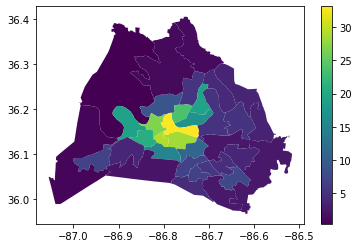

In [18]:
# Simple plot of building permit_density
districts_and_permits.plot(column = 'permit_density', legend = True);
plt.show();

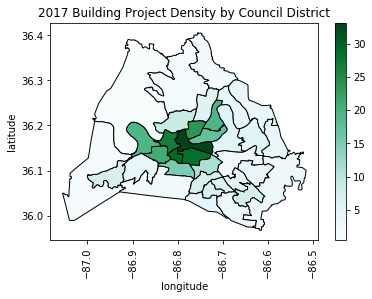

In [19]:
# Polished choropleth of building permit_density
districts_and_permits.plot(column = 'permit_density', cmap = 'BuGn', edgecolor = 'black', legend = True)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('2017 Building Project Density by Council District')
plt.show();

## Area in km squared, geometry in decimal degrees

In [20]:
# Change council_districts crs to epsg 3857
council_districts = council_districts.to_crs(epsg = 3857)
print(council_districts.crs)
print(council_districts.head())

# Create area in square km
sqm_to_sqkm = 10**6
council_districts['area'] = council_districts.geometry.area / sqm_to_sqkm

# Change council_districts crs back to epsg 4326
council_districts = council_districts.to_crs(epsg = 4326)
print(council_districts.crs)
print(council_districts.head())

{'init': 'epsg:3857', 'no_defs': True}
  district                                           geometry      area
0        1  (POLYGON ((-9674485.564711858 4354489.55569189...  0.022786
1        2  (POLYGON ((-9657970.37338656 4332440.649821124...  0.002927
2        8  (POLYGON ((-9654572.679891953 4339671.15221535...  0.002517
3        9  (POLYGON ((-9649930.991109086 4340143.58970314...  0.002883
4        4  (POLYGON ((-9656396.83322303 4307939.01495162,...  0.002052
{'init': 'epsg:4326', 'no_defs': True}
  district                                           geometry        area
0        1  (POLYGON ((-86.9073824877434 36.39051512831935...  350.194851
1        2  (POLYGON ((-86.75902399986667 36.2309080000731...   44.956987
2        8  (POLYGON ((-86.72850199989709 36.2832840002146...   38.667932
3        9  (POLYGON ((-86.68680500011934 36.2867050001350...   44.295293
4        4  (POLYGON ((-86.74488864807593 36.0531632050230...   31.441618


## Spatially joining and getting counts

In [22]:
# Create permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs = council_districts.crs, geometry = permits.geometry)
permits_geo.head()

,permit_id,issued,cost,lat,lng,geometry
0,2017032777,2017-05-24,226201.0,36.198241,-86.742235,POINT (-86.74223499999999 36.198241)
1,2017061156,2017-10-23,15000.0,36.151554,-86.830222,POINT (-86.83022199999999 36.151554)
2,2017074521,2017-11-20,13389.0,36.034239,-86.708892,POINT (-86.70889200000001 36.034239)
3,2017035041,2017-05-30,40000.0,36.128659,-86.841815,POINT (-86.841815 36.12865900000001)
4,2017000049,2017-01-09,268107.0,36.045042,-86.616211,POINT (-86.61621099999999 36.045042)


In [24]:
# Spatially join permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op = 'within')
print(permits_by_district.head(2))

# Count permits in each district
permit_counts = permits_by_district.groupby("district").size()

# Convert permit_counts to a df with 2 columns: district and bldg_permits
counts_df = permit_counts.to_frame()
counts_df.reset_index(inplace=True)
counts_df.columns = ['district', 'bldg_permits']
print(counts_df.head(2))

     permit_id      issued      cost        lat        lng  \
0   2017032777  2017-05-24  226201.0  36.198241 -86.742235   
68  2017053890  2017-09-05       0.0  36.185442 -86.768239   

                                geometry  index_right district       area  
0   POINT (-86.74223499999999 36.198241)            5        5  19.030612  
68  POINT (-86.76823900000001 36.185442)            5        5  19.030612  
  district  bldg_permits
0        1           146
1       10           119


## Building a polished Geopandas choropleth